In [53]:
import torch
from torch import nn
import matplotlib as mpl
from d2l import torch as d2l
import torch.optim as optim
import numpy as np

In [54]:
print(dir(d2l))

['Accumulator', 'AddNorm', 'AdditiveAttention', 'Animator', 'AttentionDecoder', 'BERTEncoder', 'BERTModel', 'BananasDataset', 'Benchmark', 'DATA_HUB', 'DATA_URL', 'Decoder', 'DotProductAttention', 'Encoder', 'EncoderBlock', 'EncoderDecoder', 'F', 'Image', 'MaskLM', 'MaskedSoftmaxCELoss', 'MultiHeadAttention', 'NextSentencePred', 'PositionWiseFFN', 'PositionalEncoding', 'RNNModel', 'RNNModelScratch', 'RandomGenerator', 'Residual', 'SNLIDataset', 'Seq2SeqEncoder', 'SeqDataLoader', 'Timer', 'TokenEmbedding', 'TransformerEncoder', 'VOCSegDataset', 'VOC_CLASSES', 'VOC_COLORMAP', 'Vocab', '_WikiTextDataset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_get_batch_loss_bert', '_get_mlm_data_from_tokens', '_get_next_sentence', '_get_nsp_data_from_paragraph', '_pad_bert_inputs', '_read_wiki', '_replace_mlm_tokens', 'abs', 'accuracy', 'annotate', 'arange', 'argmax', 'assign_anchor_to_bbox', 'astype', 'batchify',

##### 9.1.3 Training

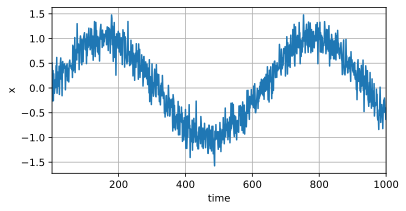

In [55]:
class Data:
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, x=None):
        # Store parameters as instance attributes
        self.batch_size = batch_size
        self.T = T if x is None else len(x)
        self.num_train = num_train
        self.tau = tau
        
        # Generate time sequence
        self.time = torch.arange(1, self.T + 1, dtype=torch.float32)
        
        # Use provided x or create synthetic time series
        if x is not None:
            self.x = torch.tensor(x, dtype=torch.float32)
        else:
            # Create synthetic time series with sinusoidal component and random noise
            self.x = torch.sin(0.01 * self.time) + torch.randn(self.T) * 0.2
        
        # Create features for regression
        self._create_features()
    
    def _create_features(self):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
    
    def get_dataloader(self, train):
        # Determine indices based on train/validation
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        
        # Select features and labels
        features = self.features[i]
        labels = self.labels[i]
        
        # Create DataLoader
        dataset = torch.utils.data.TensorDataset(features, labels)
        return torch.utils.data.DataLoader(
            dataset, 
            batch_size=self.batch_size,
            shuffle=train
        )

# Create an instance of the Data class
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [56]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, lr=0.01):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.lr = lr
        
    def forward(self, x):
        return self.linear(x)
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=self.lr)

class Trainer:
    def __init__(self, max_epochs=5):
        self.max_epochs = max_epochs
        self.loss_fn = nn.MSELoss()
    
    def fit(self, model, data):
        # Prepare train and validation dataloaders
        train_loader = data.get_dataloader(train=True)
        val_loader = data.get_dataloader(train=False)
        
        # Optimizer
        optimizer = model.configure_optimizers()
        
        # Training loop
        for epoch in range(self.max_epochs):
            model.train()
            total_loss = 0
            
            for features, labels in train_loader:
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(features.float())
                
                # Compute loss
                loss = self.loss_fn(outputs, labels.float())
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            # Print epoch statistics
            print(f'Epoch [{epoch+1}/{self.max_epochs}], Loss: {total_loss/len(train_loader):.4f}')
        
        return model

class Data:
    def __init__(self, x, tau, num_train):
        self.x = torch.tensor(x)
        self.tau = tau
        self.num_train = num_train
        self.T = len(x)
    
    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        
        # Determine indices based on train/validation
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        
        # Select features and labels
        features = self.features[i]
        labels = self.labels[i]
        
        # Create DataLoader
        dataset = torch.utils.data.TensorDataset(features, labels)
        return torch.utils.data.DataLoader(
            dataset, 
            batch_size=32,
            shuffle=train
        )

# Example usage
# Assume x is your time series data, tau is the lookback period, num_train is training data size
x = torch.randn(100)  # Example time series
tau = 3  # Lookback period
num_train = 80  # Training data size

# Create data object
data = Data(x, tau, num_train)

# Create model (note the input dimension is tau)
model = LinearRegression(input_dim=tau, lr=0.01)

# Create trainer
trainer = Trainer(max_epochs=5)

# Fit the model
trainer.fit(model, data)

Epoch [1/5], Loss: 1.4284
Epoch [2/5], Loss: 1.4900
Epoch [3/5], Loss: 1.5350
Epoch [4/5], Loss: 1.3008
Epoch [5/5], Loss: 1.3188


/tmp/ipykernel_186527/4115559513.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x)


LinearRegression(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

##### Prediction

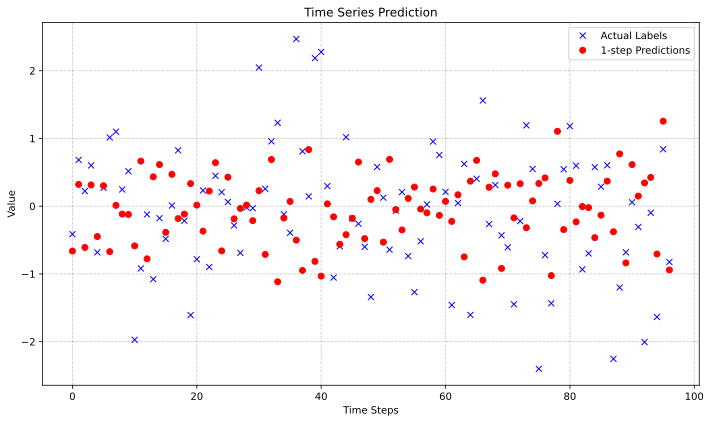

In [57]:

def plot_time_series(labels, predictions, title='Time Series Prediction'):
    """
    Plot time series labels and predictions
    
    Parameters:
    - labels: True labels/actual values
    - predictions: Predicted values
    - title: Plot title
    """
    # Ensure labels and predictions are numpy arrays
    labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels
    predictions = predictions.numpy() if isinstance(predictions, torch.Tensor) else predictions
    
    # Create a simple time array based on the length of labels
    time = np.arange(len(labels))
    
    plt.figure(figsize=(10, 6))
    
    # Plot actual labels
    plt.plot(time, labels, 'x', color='blue', label='Actual Labels')
    
    # Plot predictions
    plt.plot(time, predictions, 'o', color='red', label='1-step Predictions')
    
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plotting function
def plot_predictions(data, model):
    # Get predictions
    onestep_preds = model(data.features).detach()
    
    # Plot the data
    plot_time_series(data.labels, onestep_preds)

# Usage example
# Assuming you have already created your data and trained your model
plot_predictions(data, model)

ValueError: x and y must be the same size

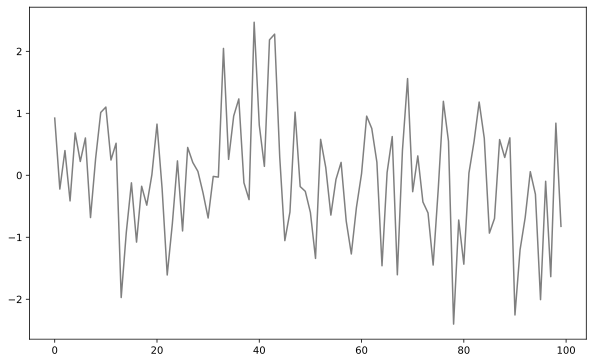

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_multistep_predictions(model, data):
    """
    Generate multi-step predictions for the entire time series
    
    Parameters:
    - model: Trained PyTorch model
    - data: Data object containing time series information
    
    Returns:
    - Numpy array of multi-step predictions
    """
    # Initialize prediction array with original data
    multistep_preds = torch.zeros(data.T)
    multistep_preds[:] = data.x

    # Model prediction loop
    for i in range(data.num_train + data.tau, data.T):
        # Reshape the input for the model
        input_seq = multistep_preds[i - data.tau:i].reshape((1, -1)).float()
        
        # Predict the next step
        with torch.no_grad():
            multistep_preds[i] = model(input_seq)

    return multistep_preds.detach().numpy()

def plot_predictions(data, onestep_preds, multistep_preds):
    """
    Plot one-step and multi-step predictions
    
    Parameters:
    - data: Data object
    - onestep_preds: One-step predictions
    - multistep_preds: Multi-step predictions
    """
    plt.figure(figsize=(10, 6))
    
    # Create time array
    time = np.arange(len(data.x))
    
    # Plot original data
    plt.plot(time, data.x, label='Original Data', color='black', alpha=0.5)
    
    # Plot one-step predictions
    plt.scatter(
        time[data.tau:data.num_train+data.tau], 
        onestep_preds, 
        label='1-step Predictions', 
        color='blue', 
        marker='x'
    )
    
    # Plot multi-step predictions
    plt.scatter(
        time[data.num_train+data.tau:], 
        multistep_preds[data.num_train+data.tau:], 
        label='Multi-step Predictions', 
        color='red', 
        marker='o'
    )
    
    plt.title('Time Series Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Usage
# Compute one-step predictions (assuming you've already done this)
onestep_preds = model(data.features).detach().numpy()

# Generate multi-step predictions
multistep_preds = generate_multistep_predictions(model, data)

# Plot predictions
plot_predictions(data, onestep_preds, multistep_preds)

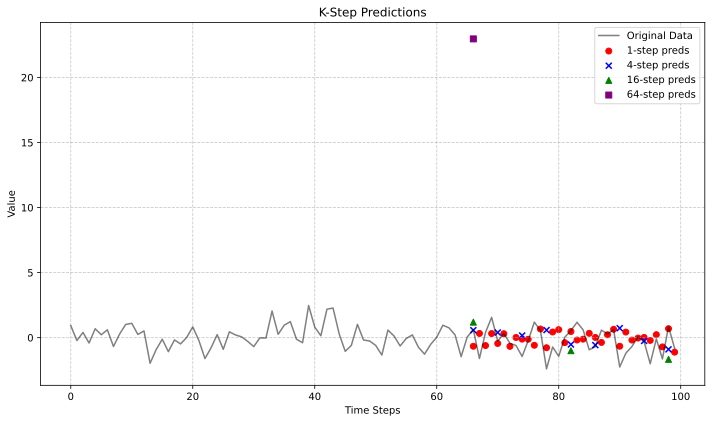

In [63]:

def k_step_pred(model, data, k):
    """
    Generate k-step predictions for multiple prediction horizons
    
    Parameters:
    - model: Trained PyTorch model
    - data: Data object containing time series
    - k: Maximum number of steps to predict
    
    Returns:
    - List of predictions for different step sizes
    """
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    
    # Predict for each step
    for i in range(k):
        # Stack features for the current prediction step
        input_features = torch.stack(features[i : i+data.tau], 1)
        
        # Get predictions
        with torch.no_grad():
            preds = model(input_features)
        
        # Append predictions
        features.append(preds.reshape(-1))
    
    return features[data.tau:]

def plot_k_step_predictions(data, model, steps=(1, 4, 16, 64)):
    """
    Plot k-step predictions for multiple prediction horizons
    
    Parameters:
    - data: Data object
    - model: Trained PyTorch model
    - steps: Tuple of prediction steps to visualize
    """
    # Generate predictions
    preds = k_step_pred(model, data, steps[-1])
    
    plt.figure(figsize=(10, 6))
    
    # Create time array
    time = np.arange(len(data.x))
    
    # Plot original data
    plt.plot(time, data.x, label='Original Data', color='black', alpha=0.5)
    
    # Plot predictions for different steps
    colors = ['red', 'blue', 'green', 'purple']
    markers = ['o', 'x', '^', 's']
    
    for idx, k in enumerate(steps):
        # Convert predictions to numpy for plotting
        k_preds = preds[k-1].detach().numpy()
        
        plt.scatter(
            time[data.tau+steps[-1]-1:][::k], 
            k_preds[::k], 
            label=f'{k}-step preds', 
            color=colors[idx], 
            marker=markers[idx]
        )
    
    plt.title('K-Step Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Usage
# Assuming you have already defined and trained your model
steps = (1, 4, 16, 64)
plot_k_step_predictions(data, model, steps)